In [1]:
import string
import random
from random import randint
import cv2
import numpy as np
import os
from PIL import Image, ImageFont, ImageDraw
import time
import re
import math
from collections import Counter
from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
# preprocessing 
path = "/home/andrew/ros_ws/src/2020T1_competition/controller/outerloop_data"
labels = ['00', '01', '02', '10', '11', '12'] # one label representing each combination of foward and turning


In [3]:
img_sets = []
for filename in os.listdir(path):
    if filename.endswith(".jpg"): 
         label = filename.split('_')[0]
         img = np.array(Image.open(path+"/"+filename))
        #  plt.imshow(img)
        #  plt.show
        #  print(path+"/"+filename)
         img_sets.append(np.array([[img, labels.index(label)]]))


10


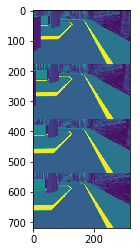

In [4]:
# making sure things are cool and good
plt.imshow(img_sets[123][0][0])
plt.show
print(labels[img_sets[123][0][1]])

In [5]:
all_dataset = np.concatenate(img_sets, axis=0)
np.random.shuffle(all_dataset)

In [6]:
X_dataset_orig = np.array([data[0] for data in all_dataset[:]])
Y_dataset_orig = np.array([[data[1]] for data in all_dataset]).T

NUMBER_OF_LABELS = 6
CONFIDENCE_THRESHOLD = 0.01

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y
  
# Normalize X (images) dataset
X_dataset = X_dataset_orig/255.

# Convert Y dataset to one-hot encoding
Y_dataset = convert_to_one_hot(Y_dataset_orig, NUMBER_OF_LABELS).T

In [7]:
n, h, w = X_dataset.shape
X_dataset = X_dataset.reshape(n, h, w, 1)
print(X_dataset.shape)

(1695, 720, 320, 1)


In [8]:
VALIDATION_SPLIT = 0.2

print("Total examples: {}\nTraining examples: {}\nTest examples: {}".
      format(X_dataset.shape[0],
             math.ceil(X_dataset.shape[0] * (1-VALIDATION_SPLIT)),
             math.floor(X_dataset.shape[0] * VALIDATION_SPLIT)))
print("X shape: " + str(X_dataset.shape))
print("Y shape: " + str(Y_dataset.shape))

Total examples: 1695
Training examples: 1356.0
Test examples: 339.0
X shape: (1695, 720, 320, 1)
Y shape: (1695, 6)


In [9]:
# model setup 
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend

In [10]:
def reset_weights(model):
    session = backend.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

In [11]:
# input_shape needs to match the input, duh
conv_model = models.Sequential()
# this creates our convolution kernel, (3,3) is the size of it
conv_model.add(layers.Conv2D(24, (3, 3), activation='relu',
                             input_shape=(180*4, 320, 1)))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(24, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(12, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Flatten())
conv_model.add(layers.Dropout(0.5))
conv_model.add(layers.Dense(6*12, activation='relu'))
conv_model.add(layers.Dense(6, activation='softmax'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [12]:
conv_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 718, 318, 24)      240       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 359, 159, 24)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 357, 157, 24)      5208      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 178, 78, 24)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 176, 76, 12)       2604      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 88, 38, 12)        0         
_________________________________________________________________
flatten (Flatten)            (None, 40128)             0

In [13]:
reset_weights(conv_model)

In [14]:
LEARNING_RATE = 5e-4
conv_model.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.RMSprop(lr=LEARNING_RATE),
                   metrics=['acc'])

In [15]:
history_conv = conv_model.fit(X_dataset, Y_dataset, 
                              validation_split=VALIDATION_SPLIT, 
                              epochs=20, 
                              batch_size=100)

Train on 1356 samples, validate on 339 samples
Epoch 1/20
1356/1356 [==============================] - 75s 56ms/sample - loss: 0.9485 - acc: 0.6342 - val_loss: 0.4575 - val_acc: 0.8289
Epoch 2/20
1356/1356 [==============================] - 74s 55ms/sample - loss: 0.3416 - acc: 0.8791 - val_loss: 0.3026 - val_acc: 0.8850
Epoch 3/20
1356/1356 [==============================] - 79s 58ms/sample - loss: 0.2740 - acc: 0.9049 - val_loss: 0.3551 - val_acc: 0.8761
Epoch 4/20
1356/1356 [==============================] - 80s 59ms/sample - loss: 0.2730 - acc: 0.9049 - val_loss: 0.2896 - val_acc: 0.8997
Epoch 5/20
1356/1356 [==============================] - 79s 58ms/sample - loss: 0.2293 - acc: 0.9226 - val_loss: 0.3219 - val_acc: 0.8879
Epoch 6/20
1356/1356 [==============================] - 78s 57ms/sample - loss: 0.2000 - acc: 0.9299 - val_loss: 0.2919 - val_acc: 0.9056
Epoch 7/20
1356/1356 [==============================] - 77s 57ms/sample - loss: 0.1873 - acc: 0.9285 - val_loss: 0.2751 - val

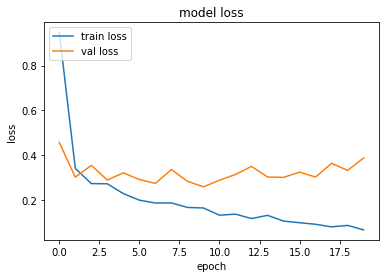

In [16]:
plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

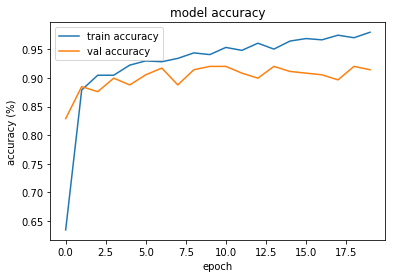

In [17]:
plt.plot(history_conv.history['acc'])
plt.plot(history_conv.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy (%)')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
plt.show()

In [20]:
saver = tf.train.Saver()
saver.save(backend.get_session(), 'outerloop-v0')

'outerloop-v0'

In [27]:
tf.keras.models.save_model(conv_model, "/home/andrew/ros_ws/src/2020T1_competition/controller")

IOError: Unable to create file (unable to open file: name = '/home/andrew/ros_ws/src/2020T1_competition/controller/my_model', errno = 21, error message = 'Is a directory', flags = 13, o_flags = 242)